In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.optimize import basinhopping

In [2]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)

In [3]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [4]:
node_left, edge_left, timestamp_left = return_nm(df_left)

In [5]:
# node_leftとedge_leftを組みにしてdf_leftを作成
df_left = pd.DataFrame({'node': node_left, 'edge': edge_left})
# df_leftのnodeを昇順にして並び替え
df_left = df_left.sort_values(by='node')
# インデックスを振り直す
df_left = df_left.reset_index(drop=True)
df_left.head()

,node,edge
0,106,190
1,136,221
2,173,312
3,215,368
4,217,494


In [6]:
# modelを定義
def model_uniform(x, kappa):
    m = x[0]
    kappa = np.abs(kappa)
    Np = (1 + np.sqrt(1 + ((32 * np.abs(m)) / np.abs(kappa))) ) / 2
    res = Np * (1 - (2 / (kappa * Np)) * (1 - ((1 - (kappa / 2)) ** Np) ))
    return res

In [7]:
# 残差関数の定義
def residual_uniform(params, x, y):
    return y - model_uniform(x, *params)

In [11]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

# result = optimize.least_squares(residual_uniform, x0=[0.05], args=(edge_norm_left, node_norm_left))
# optimized_kappa = result.x

result, _ = optimize.curve_fit(model_uniform, edge_left, node_left, p0=[0.001])
optimized_kappa = result[0]

print(r"kappa:", optimized_kappa)

+------------------+
| Estimating       |
+------------------+
kappa: 0.05997235728383503


In [12]:
# 元の関数に代入する
kappa_hat = optimized_kappa
print("+------------------+")
Np_estimated = []
for i in range(len(df_left["edge"])):
    Np_estimated.append( (1 + np.sqrt(1 + (32 * df_left["edge"][i] / kappa_hat))) / 2 )

# Eq8, 9
N = []
M = []
for i in range(len(Np_estimated)):
    N.append( Np_estimated[i] * ( 1 - (2/(Np_estimated[i] * kappa_hat)) * (1 - (1 - (kappa_hat/2))**Np_estimated[i] ) ) )
    M.append( ( kappa_hat * Np_estimated[i] * (Np_estimated[i] - 1) ) * (1 / 8) )

print("|      DONE        |")
print("+------------------+")
print("| Np: ", Np_estimated[0])
print("| kappa: ", kappa_hat)
print("| N: ", N[0])
print("| M: ", M[0])
print("+------------------+")

+------------------+
|      DONE        |
+------------------+
| Np:  159.7019474818014
| kappa:  0.05997235728383503
| N:  126.61117138008991
| M:  190.0
+------------------+


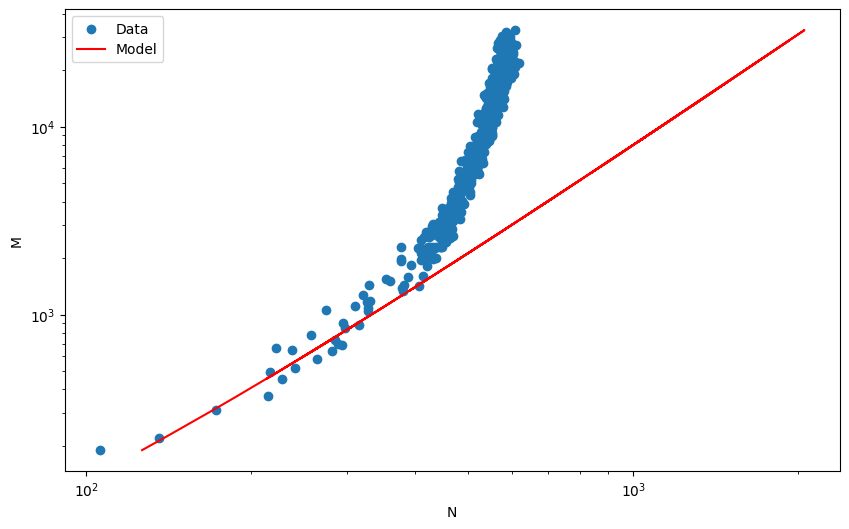

In [13]:
# 可視化
plt.figure(figsize=(10, 6))
plt.scatter(df_left["node"], df_left["edge"], label='Data')
plt.plot(N, M, label='Model', color='red') 
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [14]:
# 正規化
df_left["node_norm"] = df_left["node"] - df_left["node"].min() + 2
df_left["edge_norm"] = df_left["edge"] - df_left["edge"].min() + 1

In [15]:
node_norm_left = df_left['node_norm'].values
edge_norm_left = df_left['edge_norm'].values

In [16]:
# 元の関数に代入する
kappa_norm_hat = optimized_kappa
print("+------------------+")
Np_norm_estimated = []
for i in range(len(df_left["edge_norm"])):
    Np_norm_estimated.append( (1 + np.sqrt(1 + (32 * df_left["edge_norm"][i] / kappa_norm_hat))) / 2 )

# Eq8, 9
N_norm = []
M_norm = []
for i in range(len(Np_norm_estimated)):
    N_norm.append( Np_norm_estimated[i] * ( 1 - (2/(Np_norm_estimated[i] * kappa_norm_hat)) * (1 - (1 - (kappa_norm_hat/2))**Np_norm_estimated[i] ) ) )
    M_norm.append( ((kappa_norm_hat* (Np_norm_estimated[i])**2) - (kappa_norm_hat*Np_norm_estimated[i])  * (1 / 8) ))

print("|      DONE        |")
print("+------------------+")
print("| Np: ", Np_norm_estimated[0])
print("| kappa: ", kappa_norm_hat)
print("| N: ", N_norm[0])
print("| M: ", M_norm[0])
print("+------------------+")

+------------------+
|      DONE        |
+------------------+
| Np:  12.060483982310341
| kappa:  0.05997235728383503
| N:  1.811905711080129
| M:  8.6328836976027
+------------------+


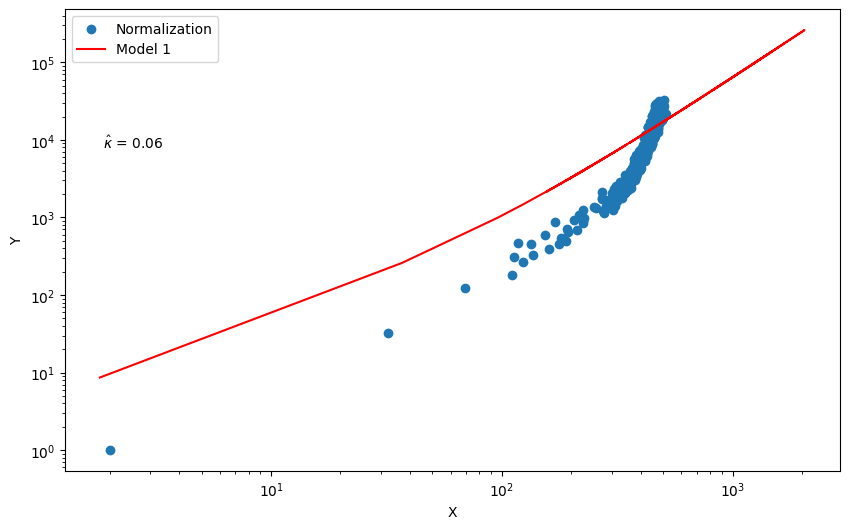

In [27]:
# 可視化
plt.figure(figsize=(10, 6))
plt.scatter(df_left["node_norm"], df_left["edge_norm"], label='Normalization')
plt.plot(N_norm, M_norm, label='Model 1', color='red')
kappa_norm_hat = round(kappa_norm_hat, 4)
plt.text(0.05, 0.70, r'$\hat{\kappa}$ = ' + str(kappa_norm_hat), transform=plt.gca().transAxes)
plt.xlabel('X')
plt.ylabel('Y')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()